# Figure 11 - 3D corner plot
This Jupyter notebooks reproduces Figure 11. The output .png and .pdf files are saved in <em>/figures</em>. Marginalized distributions (corner plot) from the 1D retrieval on the 3D GCM simulated HRS data set show that part of the explored multi-dimensional parameter space is significantly better matched to the data. 

In [1]:
%matplotlib inline
import corner
import pymultinest
import numpy as np
import sys
import json
import pickle
from matplotlib import pyplot as plt
import os
import re
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Define some plotting functions and parameters.

In [2]:
tableau20 = [
    (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)
]
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
params_unit = {
    "logH2O" : '',
    "logCO" : '',
    "T0" : 'K',
    "logP1" : 'bar',
    "logP2" : 'bar',
    "logP3" : 'bar',
    "a1" : '',
    "a2" : '',
    "Kp" : 'km/s',
    "vsys" : 'km/s',
    "loga" : '',
    "dphi" : '',
    'vbroad' : 'km/s'
}
    
params_label = {
    "logH2O" : "\n"r"$\log{X_{\rm{0,H_2O}}}$""\n",
    "logCO" : "\n"r"$\log{X_{\rm{CO}}}$""\n",
    "T0" : "\n"r"$T_{\rm{0}}$""\n",
    "logP1" : "\n"r"$\log{P_{\rm{1}}}$""\n",
    "logP2" : "\n"r"$\log{P_{\rm{2}}}$""\n",
    "logP3" : "\n"r"$\log{P_{\rm{3}}}$""\n",
    "a1" : "\n"r"$\alpha_{\rm{1}}$""\n",
    "a2" : "\n"r"$\alpha_{\rm{2}}$""\n",
    "Kp" : "\n"r"$\Delta K_{\rm{p}}$""\n",
    "vsys" : "\n"r"$\Delta v_{\rm{sys}}$""\n",
    "loga" : "\n"r"$\log{a}$""\n",
    "dphi" : "\n"r"$\Delta \phi$""\n",
    "vbroad" : "\n"r"$\delta v_{\rm{broad}}$""\n",
}

params_precision = {
    "logH2O" : 1,
    "logCO" : 1,
    "T0" : 0,
    "logP1" : 1,
    "logP2" : 1,
    "logP3" : 1,
    "a1" : 2,
    "a2" : 2,
    "Kp" : 1,
    "vsys" : 1,
    "loga" : 2,
    "dphi" : 2,
    "vbroad" : 1
}

# MS09 TP profile for plotting
def TP_MS(P, T0, P1, P2, P3, a1, a2, beta=0.5, Tmin=500., Tmax=5000.):
    """
    TP-parameterisation from Madhusudhan & Seager 2009.

    Input parameters:
    P = pressure array in order of high to low pressures
    T0, P1, P2, P3, a1, a2, beta = see paper
    Tmin = minimum temperature, prevent profiles from becoming too cold

    Output parameters:
    T = temperature array
    """
    #P = P[::-1] # reverse array to be low -> high pressure
    nlayers = P.shape[0] # nlayers
    Tarr = np.zeros(nlayers) # allocate memory for temperature array
    P0 = P[0] # first pressure point

    # Layer 1
    Tarr1 = (np.log(P/P0)/a1)**(1./beta)+T0
    Tarr[P < P1] = Tarr1[P < P1]

    # Layer 2
    T2 = (np.log(P1/P0)/a1)**(1./beta)+T0-(np.log(P1/P2)/a2)**(1./beta)
    Tarr2 = (np.log(P/P2)/a2)**(1./beta)+T2
    Tarr[P >= P1] = Tarr2[P >= P1]

    # Layer 3
    Tarr[P >= P3] = Tarr2[P >= P3][0]

    # Some boundary conditions
    Tarr[Tarr <= Tmin] = Tmin
    Tarr[Tarr >= Tmax] = Tmax
    return Tarr

def compute_H2O_dissociation_profile(P, T, logH2O):
    """Compute water chemical profile as function of pressure
    based on the results from Parmetier et al. 2018."""
    a = 10**logH2O
    b = 10**(2.0 * np.log10(P) + 4.83 * 1e4/T - 15.9)
    c = 1./np.sqrt(a) + 1./np.sqrt(b)
    return (1./c)**2

def plot_pt_profile(ax):
    NN = 1000
    draws = np.random.randint(len(samples), size=NN)
    xrand = samples[draws, :]
    np.savetxt('../data/fms/xrand_3D.npy', xrand)
    Tarr = []
    logH2Oarr = []
    logP = np.arange(-6., 2.5, 0.08)+0.08
    P = 10.0**logP
    ticksize=32

    logP1_values = []
    logP2_values = []
    logP3_values = []
    for i in range(NN):
        x = xrand[i, :]
        logCO, logH2O_0, T0, logP1, logP2, logP3, a1, a2, kp, vsys, vbroad = x
        T = TP_MS(P, T0, 10**logP1, 10**logP2, 10**logP3, a1, a2)
        logH2O = compute_H2O_dissociation_profile(P, T, logH2O_0)
        Tarr = np.concatenate([Tarr, T])
        logH2Oarr = np.concatenate([logH2Oarr, logH2O])
        logP1_values.append(logP1)
        logP2_values.append(logP2)
        logP3_values.append(logP3)
        
    logP1= np.median(logP1_values)
    logP2= np.median(logP2_values)
    logP3= np.median(logP3_values)
    
    plt.axhline(10**logP1, color='k', ls='--')
    plt.annotate('$P_1$', xy=(3350,10**logP1), va='bottom', ha='center', fontsize=ticksize*1.)
    plt.axhline(10**logP2, color='k', ls='--')
    plt.annotate('$P_2$', xy=(3350,10**logP2), va='bottom', ha='center', fontsize=ticksize*1.)
    plt.axhline(10**logP3, color='k', ls='--')
    plt.annotate('$P_3$', xy=(3350,10**logP3), va='bottom', ha='center', fontsize=ticksize*1.)

    Tarr = Tarr.reshape(NN, P.shape[0])
    Tmedian = np.zeros(P.shape[0])
    Tlow_1sig = np.zeros(P.shape[0])
    Thigh_1sig = np.zeros(P.shape[0])
    Tlow_2sig = np.zeros(P.shape[0])
    Thigh_2sig = np.zeros(P.shape[0])
    
    logH2Oarr = logH2Oarr.reshape(NN, P.shape[0])
    logH2Omedian = np.zeros(P.shape[0])
    logH2Olow_1sig = np.zeros(P.shape[0])
    logH2Ohigh_1sig = np.zeros(P.shape[0])
    logH2Olow_2sig = np.zeros(P.shape[0])
    logH2Ohigh_2sig = np.zeros(P.shape[0])

    for i in range(P.shape[0]):
        percentiles = np.percentile(Tarr[:, i], [4.55, 15.9, 50, 84.1, 95.45])
        Tlow_2sig[i] = percentiles[0]
        Tlow_1sig[i] = percentiles[1]
        Tmedian[i] = percentiles[2]
        Thigh_1sig[i] = percentiles[3]
        Thigh_2sig[i] = percentiles[4]
        
    for i in range(P.shape[0]):
        percentiles = np.percentile(logH2Oarr[:, i], [4.55, 15.9, 50, 84.1, 95.45])
        logH2Olow_2sig[i] = percentiles[0]
        logH2Olow_1sig[i] = percentiles[1]
        logH2Omedian[i] = percentiles[2]
        logH2Ohigh_1sig[i] = percentiles[3]
        logH2Ohigh_2sig[i] = percentiles[4]

    plt.fill_betweenx(P, Tlow_1sig, Thigh_1sig, facecolor=color,
                  edgecolor='None', alpha=0.5, label=r'1$\sigma$')
    plt.fill_betweenx(P, Tlow_2sig, Thigh_2sig, facecolor=color,
                  edgecolor='None', alpha=0.25, label=r'2$\sigma$')
    ax.axis([500, 4000, 30, 1E-5])
    ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000])
    plt.semilogy()
    ax.plot(Tmedian, P, color='k', lw=2)

    plt.xlabel('Temperature [K]', size=labelsize)
    plt.ylabel('Pressure [bar]', size=labelsize)
    plt.minorticks_on()
    plt.xlim(0,5000)
    plt.ylim(10**2.5, 1e-6)
    plt.tick_params(length=10, width=1, labelsize=ticksize*1., which='major')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    d=[P,Tlow_2sig, Tlow_1sig, Tmedian, Thigh_1sig, Thigh_2sig]
    e=[P,logH2Olow_2sig, logH2Olow_1sig, logH2Omedian, logH2Ohigh_1sig, logH2Ohigh_2sig]
    return ax, d, e

Plot corner plot.

/var/folders/fr/d4gym27d0y1dw670nr2vpn5c0000gr/T/ipykernel_26239/669234154.py:78: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.ticker.NullLocator'>
  ax.locator_params(axis='both', nbins=3)


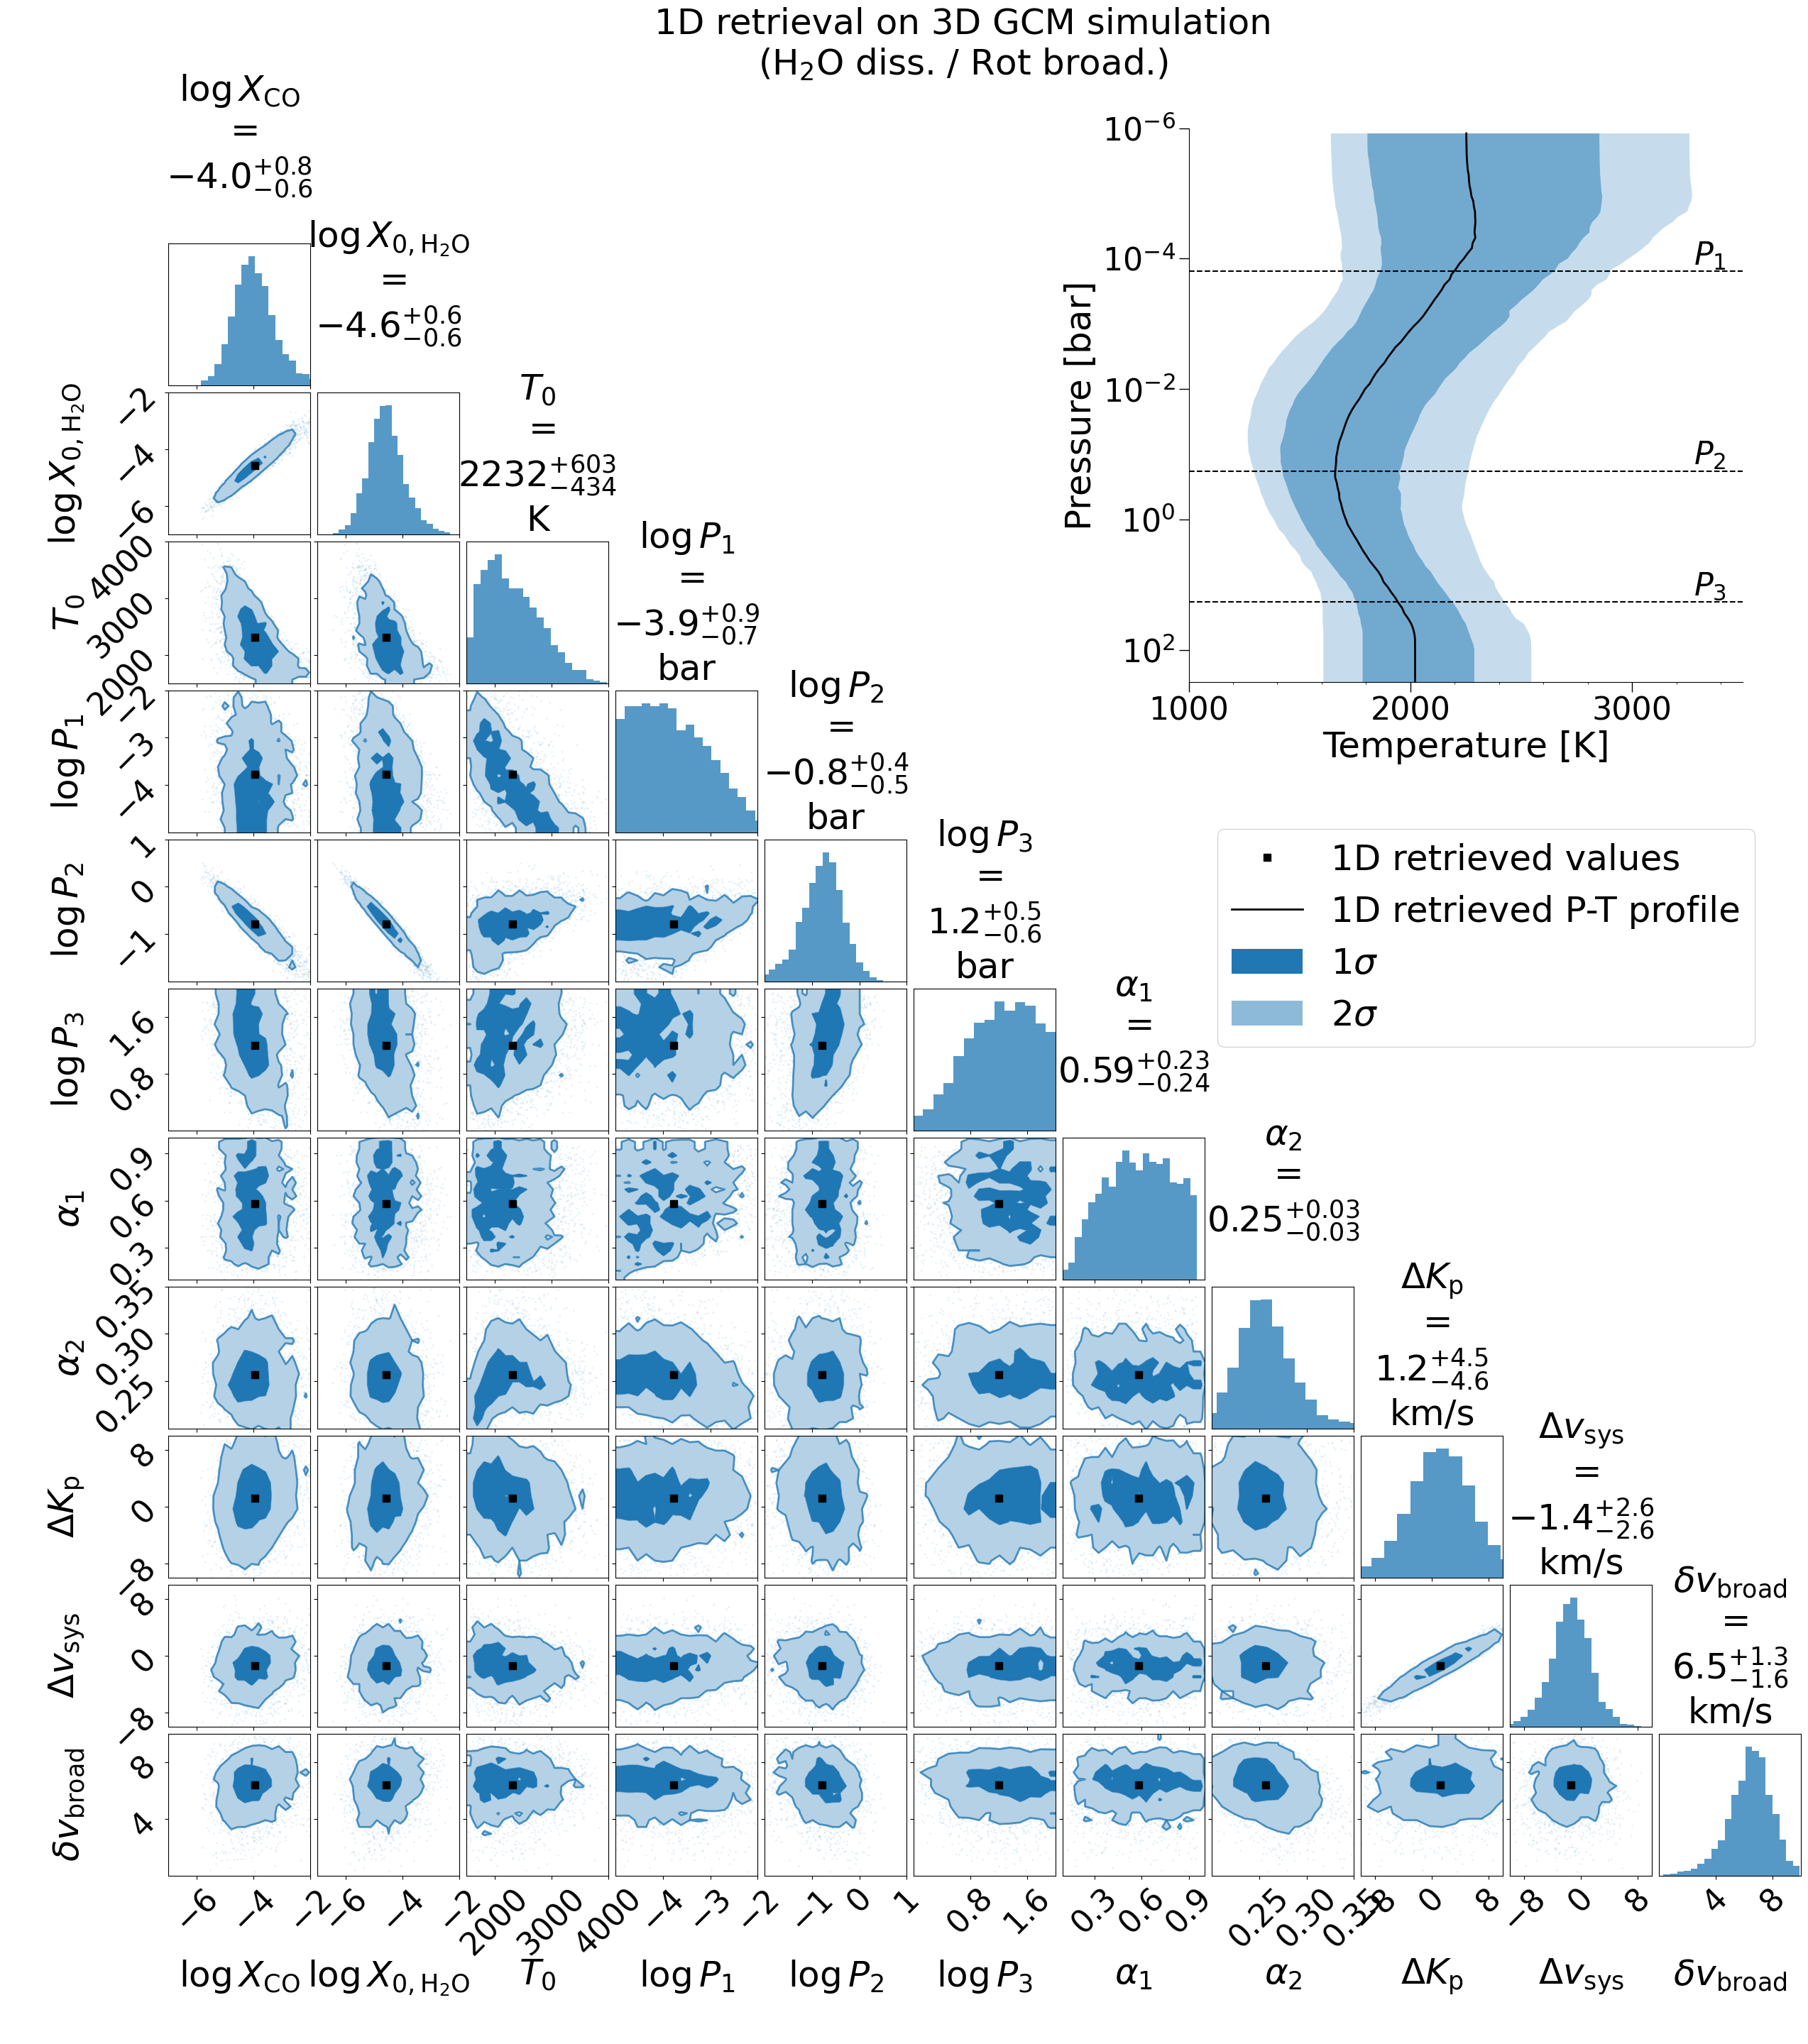

In [3]:
dirin = '../data/retrieval_output_3D_Doppler_on_H2O_dissociated/'
dirin = '../data/pmn_out_3D'

save_plot=True
prefix=dirin+'/template_'

params = json.load(open(prefix+'params.json'))
ndim = len(params)

sigma_levels=[1,2]
plot_ranges=None
add_legend=True
labelsize=36
ticksize=32

a = pymultinest.Analyzer(n_params=ndim, outputfiles_basename=prefix, verbose=False)
weights = a.get_data()[:,0]
mask = weights > 1e-5

data = a.get_data()[:,2:]

labels = [params_label[p] for p in params]
units = [params_unit[p] for p in params]

plot_ranges = [(-7,-2),(-7,-2),(1500,4000),(-5.,-2),(-2.,1.),(0.,2.),
              (0.1,1.),(0.2,0.35),(-10,10),(-10,10), (0,10)]
expected_values = [-3.75, -4.5, 2550, 0.5, 0.5, 0.5, 0.62, 0.5, 0, 0, 0, 0]

color='tab:blue'

i_CO = [i for i in range(len(params)) if params[i] == 'logCO'][0]
CO_stats = (
    a.get_stats()['marginals'][i_CO]['median'],
    -a.get_stats()['marginals'][i_CO]['median']+a.get_stats()['marginals'][i_CO]['1sigma'][0],
    -a.get_stats()['marginals'][i_CO]['median']+a.get_stats()['marginals'][i_CO]['1sigma'][1]
)

# Regular expression to match all decimal numbers positive or negative
pattern = r'[-+]?\d*\.\d+'

fig = None

levels = [1 - np.exp(-(sigma)**2/2) for sigma in sigma_levels]
samples = data[mask]
fig = corner.corner(samples, labels=labels,
                       quantiles=[],
                       show_titles=True, color=color, label_kwargs={'fontsize':labelsize}, title_kwargs={'fontsize':labelsize},
                      fill_contours=True, plot_density=False, plot_contours=True, plot_points=True,
                    contour_kwargs={'linewidths':2, 'alpha':0.75},
                      hist_kwargs={'lw':2, 'histtype':'stepfilled',
                                   'alpha':0.75},fig=fig, levels=levels)

mean_values = np.mean(data[mask], axis=0)

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    text = axes[i,i].get_title().strip('\n')
    s = text[text.rfind('=')+1:]
    matches = np.array(re.findall(pattern, s), dtype='float')
    precision = params_precision[params[i]]
    values = r"${" + "{:.{}f}".format(np.round(matches[0], precision), precision) + "}_" + \
    "{" + "{:.{}f}".format(np.round(matches[1], precision), precision) + "}^" + \
    "{+" + "{:.{}f}".format(np.round(matches[2], precision), precision) + "}$"
    
    axes[i,i].set_title('')
    t = text[:text.rfind('=')+1] + '\n' + values +'\n'+units[i]
    axes[i,i].annotate(t, xy=(0.5,1.075), xycoords='axes fraction', ha='center', size=labelsize, color='k')
    
for i in range(ndim):
    ax = axes[i, i]
    ax.set_xlim(plot_ranges[i][0], plot_ranges[i][1])
    ax.tick_params(labelsize=ticksize)
    ax.locator_params(axis='both', nbins=3)

# Loop over the marginal
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.set_xlim(plot_ranges[xi][0], plot_ranges[xi][1])
        ax.set_ylim(plot_ranges[yi][0], plot_ranges[yi][1])
        ax.tick_params(labelsize=ticksize)
        ax.plot(mean_values[xi], mean_values[yi], "sk", ms=7.5)
        ax.locator_params(axis='both', nbins=3)

        
ax_pt = fig.add_axes([0.63, 0.73, 0.32, 0.32])
ax_pt, d, e = plot_pt_profile(ax_pt)
ax_pt.axvline(10**-3.9)

ax_pt.set_xlim(1000,3500)
pickle.dump(d, open(dirin+'/pt_profile.pic', 'wb'))
pickle.dump(e, open(dirin+'/H2O_profile.pic', 'wb'))
pickle.dump(CO_stats, open(dirin+'/CO_stats.pic', 'wb'))

legend_elements = [
    Line2D([0], [0], label='1D retrieved values', marker='s', markersize=7.5, color='k', ls=''),
    Line2D([0], [0], label='1D retrieved P-T profile', color='k', lw=2),
    Patch(facecolor='tab:blue', alpha=1, label=r'1$\sigma$'),
    Patch(facecolor='tab:blue', alpha=0.5, label=r'$2\sigma$')
]
axes[4,6].legend(handles=legend_elements, bbox_to_anchor=(5., 1.2), fontsize=ticksize, frameon=True, prop={'size': labelsize})
        
plt.suptitle(r'1D retrieval on 3D GCM simulation' + '\n' + r'(H$_2$O diss. / Rot broad.)', size=labelsize, y=1.12)
dirout = '../figures/'
if save_plot:
    plt.savefig(os.path.join(dirout, f'Fig11_3D_corner_plot.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(dirout, f'Fig11_3D_corner_plot.png'), bbox_inches='tight', dpi=200)
plt.show()